In [1]:
# improt the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
!pip install tabulate
from tabulate import tabulate
import os
import matplotlib.image as mpimg
import random
import cv2

pd.set_option('display.max_columns', None)

# Ignore warning
import warnings
warnings.filterwarnings('ignore')

In [ ]:
def create_dataframe_from_images(image_folder_path):
    image_paths = []

    # Count total files to set up tqdm
    total_files = sum(len(files) for _, _, files in os.walk(image_folder_path))

    with tqdm(total=total_files, desc="Processing images") as pbar:
        for root, dirs, files in os.walk(image_folder_path):
            for file in files:
                if file.endswith(".jpg") or file.endswith(".jpeg"):
                    image_paths.append(os.path.join(root, file))
                    pbar.update(1)

    data = {'Image_Path': image_paths}
    df = pd.DataFrame(data)
    return df

In [ ]:
folder_path = '/content/drive/MyDrive/Hands Dataset/Dataset'
dataset = create_dataframe_from_images(folder_path)
dataset.head()

Processing images:   0%|          | 0/30576 [00:00<?, ?it/s]

,Image_Path
0,/content/drive/MyDrive/Hands Dataset/Dataset/2...
1,/content/drive/MyDrive/Hands Dataset/Dataset/2...
2,/content/drive/MyDrive/Hands Dataset/Dataset/2...
3,/content/drive/MyDrive/Hands Dataset/Dataset/2...
4,/content/drive/MyDrive/Hands Dataset/Dataset/2...


In [ ]:
dataset_org = dataset.copy()

In [ ]:
dataset['Image_Path__'] = dataset['Image_Path'].apply(lambda x: x.replace("/Augmented", ""))

In [ ]:
dataset['age'] = dataset['Image_Path__'].apply(lambda x: x.split("/")[-2]).astype(int)
dataset.head()

,Image_Path,Image_Path__,age
0,/content/drive/MyDrive/Hands Dataset/Dataset/2...,/content/drive/MyDrive/Hands Dataset/Dataset/2...,27
1,/content/drive/MyDrive/Hands Dataset/Dataset/2...,/content/drive/MyDrive/Hands Dataset/Dataset/2...,27
2,/content/drive/MyDrive/Hands Dataset/Dataset/2...,/content/drive/MyDrive/Hands Dataset/Dataset/2...,27
3,/content/drive/MyDrive/Hands Dataset/Dataset/2...,/content/drive/MyDrive/Hands Dataset/Dataset/2...,27
4,/content/drive/MyDrive/Hands Dataset/Dataset/2...,/content/drive/MyDrive/Hands Dataset/Dataset/2...,27


In [ ]:
df_info = pd.read_csv("/content/drive/MyDrive/Hands Dataset/HandInfo.csv")
df_info.head()

,id,age,gender,skinColor,accessories,nailPolish,aspectOfHand,imageName,irregularities
0,0,27,male,fair,0,0,dorsal right,Hand_0000002.jpg,0
1,0,27,male,fair,0,0,dorsal right,Hand_0000003.jpg,0
2,0,27,male,fair,0,0,dorsal right,Hand_0000004.jpg,0
3,0,27,male,fair,0,0,dorsal right,Hand_0000005.jpg,0
4,0,27,male,fair,0,0,dorsal right,Hand_0000006.jpg,0


In [ ]:
# check number of persons per age
df_no_person_per_age = df_info.groupby('age')['id'].nunique().to_frame().reset_index().rename(columns={'id': 'no_person_per_age'})
df_no_person_per_age

,age,no_person_per_age
0,18,1
1,19,2
2,20,39
3,21,80
4,22,36
5,23,16
6,24,2
7,25,2
8,26,2
9,27,1


In [ ]:
# Filter the DataFrame to get ages where the number of people per age is >= 2
grouped_ages = df_no_person_per_age[df_no_person_per_age['no_person_per_age'] >= 2]['age'].values.tolist()
print(grouped_ages)

[19, 20, 21, 22, 23, 24, 25, 26]


In [ ]:
dataset_new = dataset[dataset['age'].isin(grouped_ages)]

In [ ]:
# Define a function to get the first 795 rows from each group
def get_first_795(group):
    return group.head(795)

grouped_dataset = dataset_new.groupby('age').apply(get_first_795)
grouped_dataset = grouped_dataset.reset_index(drop=True)
grouped_dataset.head()

,Image_Path,Image_Path__,age
0,/content/drive/MyDrive/Hands Dataset/Dataset/1...,/content/drive/MyDrive/Hands Dataset/Dataset/1...,19
1,/content/drive/MyDrive/Hands Dataset/Dataset/1...,/content/drive/MyDrive/Hands Dataset/Dataset/1...,19
2,/content/drive/MyDrive/Hands Dataset/Dataset/1...,/content/drive/MyDrive/Hands Dataset/Dataset/1...,19
3,/content/drive/MyDrive/Hands Dataset/Dataset/1...,/content/drive/MyDrive/Hands Dataset/Dataset/1...,19
4,/content/drive/MyDrive/Hands Dataset/Dataset/1...,/content/drive/MyDrive/Hands Dataset/Dataset/1...,19


In [ ]:
grouped_dataset['age'].value_counts()

age
19    795
20    795
21    795
22    795
23    795
24    795
25    795
26    795
Name: count, dtype: int64

In [ ]:
def check_distribution(dataset):
  # Distribution of Age
  plt.figure(figsize=(15, 6))
  sns.countplot(data=dataset, x='age', palette='Set3')
  plt.title('Count Plot by Age')
  plt.xlabel('Age')
  plt.ylabel('Count')

  ax = plt.gca()
  for p in ax.patches:
      ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')

  plt.show()

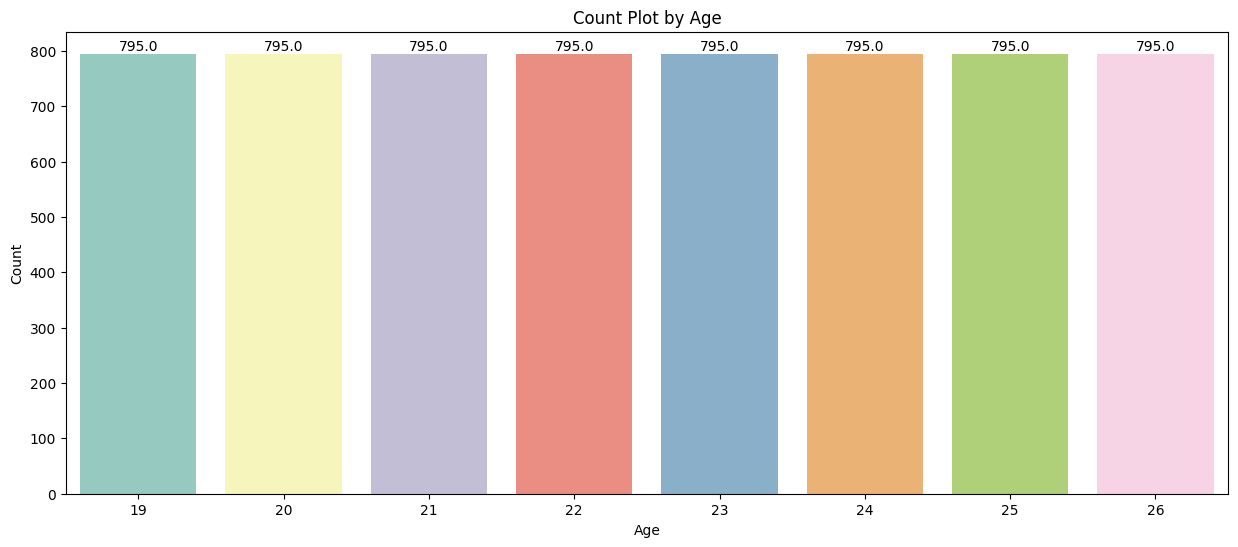

In [ ]:
check_distribution(grouped_dataset)

In [ ]:
df = grouped_dataset.copy()

In [ ]:
df.shape

(6360, 3)

In [ ]:
# Select n random images and display images along with its Age
def plot_random_images(df, total_image=2):
    fig, axes = plt.subplots(1, total_image,figsize=(14,2))
    images_data = list(zip(df['Image_Path'],df['age']))
    samples = random.sample(images_data,total_image)
    for ax, (image, label) in zip(axes, samples):
        image = mpimg.imread(image)
        ax.set_axis_off()
        ax.imshow(image, cmap = 'binary')
        ax.set_title(f'{label}')

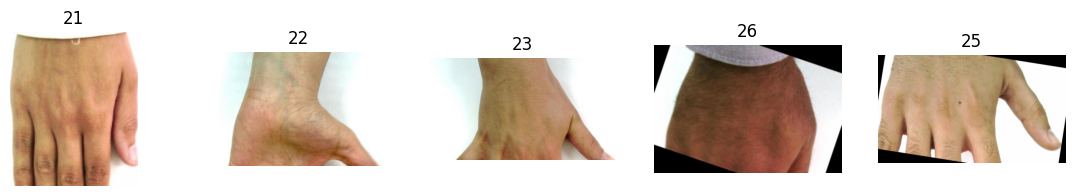

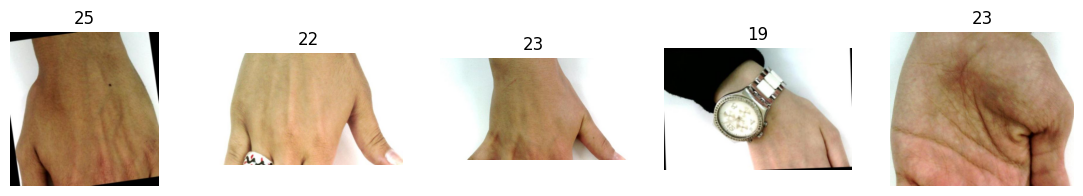

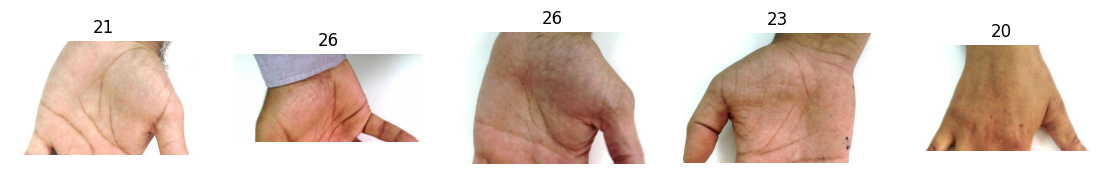

In [ ]:
# plot original dataset random images
plot_random_images(df, 5)
plot_random_images(df, 5)
plot_random_images(df, 5)

In [ ]:
from keras.applications.densenet import DenseNet201
from tensorflow.keras.preprocessing.image import img_to_array

### **Save Images Data into Numpy Arrays**

In [ ]:
height = 32
width = 64

In [ ]:
def get_images_data_arrays(df):
  data = []
  labels = []
  for img, age in tqdm(list(zip(df['Image_Path'], df['age']))):
      try:
          img_read = plt.imread(img)
          if len(img_read.shape) == 2:
              img_read = cv2.cvtColor(img_read, cv2.COLOR_GRAY2RGB)
          elif len(img_read.shape) == 3:
              img_read = cv2.cvtColor(img_read, cv2.COLOR_BGR2RGB)
          img_resize = cv2.resize(img_read, (height, width))
          img_array = img_to_array(img_resize)

          # Normalize the image
          img_array /= 255.0

          data.append(img_array)
          labels.append(age)
      except:
          None
  return np.array(data), np.array(labels)

In [ ]:
image_data, labels = get_images_data_arrays(df)

  0%|          | 0/6360 [00:00<?, ?it/s]

In [ ]:
len(image_data)

6360

In [ ]:
np.save('/content/drive/MyDrive/Hands Dataset/images', image_data)
np.save('/content/drive/MyDrive/Hands Dataset/labels', labels)

### **load data from numpy file**

In [ ]:
image_data = np.load('/content/drive/MyDrive/Hands Dataset/images.npy')
labels = np.load('/content/drive/MyDrive/Hands Dataset/labels.npy')

In [ ]:
height = 32
width = 64

# Features Extraction through CNN (DenseNet201)
The feature extraction process involved feeding each in-put image through a series of dense blocks. Each block consisted of multiple convolution layers with batch nor-malisation and a Rectified Linear Unit (ReLU) activation function (Huang et al. 2017). A series of convolution and pooling operations were performed on the input to contin-uously extract features from the image. The output of the feature extraction process was a vector of numeric features that represent the partial dorsal and palmar hand images. Each element in the vector represented different levels of abstraction, starting from simple features like edges and textures to more complex information like object shapes and structures. 

# Code Explanation for Feature Extraction through CNN(DenseNet201):
get_features_through_cnn is used to extract features from images using a pre-trained DenseNet201 model. The function 'get_features_through_cnn takes two arguments 'image_data' which contains image data and 'labels' contains the corresponding labels for the images.
Pre-trained DenseNet201 is loaded using the DensNet201 function from keras with the parameter 'weights ='imagenet' which loads the weight pre-trained in the ImageNet dataset. The 'input_shape specifies the shape of the input images(width, height, channel)(64,32,RGB)
In the next step a loop iterates over all the layers in the model and for each layer, 'layer.trainable' is set to 'False' including the top layer and it freezes the weights of all layers in the pre-trained model, ensuring that they are not updated during the training.
The pre-trained model is then used to extract features from the input 'image_data using the 'predict method. It generates a features vector for each image in the dataset.
The extracted features are reshaped into a two-dimensional array where each row represents an image and each column represents a feature.
The feature vectors are stored in a Pandas DataFrame as df_data with columns labelled as 'feature_0, feature_1... upto the number of features it extracts.
The labels are added as a column to the DataFrame. The DataFrame is then copied into another DataFrame 'df' features X and labels y are extracted df for further processing.

In [ ]:
def get_features_through_cnn(image_data, labels):
  model = DenseNet201(weights='imagenet',input_shape=(width,height,3), include_top=False)
  # don't train existing weights
  for layer in model.layers:
    layer.trainable = False

  feature_extractor = model.predict(image_data)

  features = feature_extractor.reshape(feature_extractor.shape[0], -1)

  cols = ['feature_'+str(i) for i in range(features.shape[1])]

  # make a dataframe
  df_data = pd.DataFrame(features, columns=cols)
  df_data['label'] = labels

  df = df_data.copy()

  X = df.drop('label', axis = 1).values
  y = df['label'].values

  return X, y

# PCA
Principal Component Analysis (PCA) is a popular technique for dimensionality reduction and feature extraction. . In the context of hand image feature extraction, PCA can reduce the complexity of the feature space while retaining essential hand pose or gesture information. By applying PCA to the extracted features from DenseNet201, we can further decrease dimensionality while preserving important information.

The below code explains the 'plot_cumm_var' is used to plot the cumulative variance ratio of Principal Component Analysis(PCA) and the threshold value and takes three arguments 'pca' is the model of principal component analysis, 'dataset_name' is the name of the dataset and optional threshold value for the cumulative variance.
'pc_list and pca_variance function generates a list of principal component 'pc_list' and calculates the cumulative explained variance ratio ('pca_varaince') using the 'explained_variance_ratio' attribute of the PCA model 'pca'
A pandas DataFrame 'pca_df' is created to store the principal component names and their corresponding cumulative variance. If a threshold is provided the DataFrame is filtered to use only pc with cumulative variance less than or equal to the threshold.
using a Matplotlib a plot is created to visualize the cumulative variance against the pc. The cumulative variance is plotted against the pc indicates 'pc_list'. If threshold value is provided a dashed line is drawn to mark the threshold value. For x-axis and y-axis plots are set for better visualization. The x-axis labels are rotated 90 degrees for better readability, the plot grid is turned off to reduce clutter. The plot is saved as a png file named as PCA. png and displayed using plt.show() the total number of features considered for PCA is printed and returns the total number of features considered for PCA.

In [ ]:
def plot_cumm_var(pca, dataset_name, threshold=None):
    pc_list = ["PC"+str(i) for i in list(range(1, len(pca.explained_variance_ratio_.tolist())+1))]
    pca_variance = np.cumsum(pca.explained_variance_ratio_.tolist())
    pca_df = pd.DataFrame({'pca_feature':pc_list,'cummulative variance':pca_variance})
    pca_df = pca_df[pca_df['cummulative variance']<=threshold]
    pca_df['cummulative variance'] = round(pca_df['cummulative variance']*100,2)
    # print(tabulate(pca_df, headers = 'keys', tablefmt = 'psql'))
    plt.figure(figsize=(15,5))
    plt.plot(pc_list,pca_variance,c='red',marker='X', linewidth=2,markersize=9)
    if threshold:
        # Draw line set threshold
        value99 = pca_variance[-1]*threshold
        plt.hlines(y = value99, xmin=0, xmax=len(pca.explained_variance_ratio_.tolist()), color = 'r', linestyles = 'dashed')
    plt.title(f"PCA Variance Graph ({dataset_name} Dataset) - Total Best Feature {len(pca_df)}", fontsize=18)
    plt.xlabel("PCs",fontsize=18)
    plt.ylabel("Cummulative Variance",fontsize=18)
    plt.xticks(rotation=90)
    plt.grid(False)
    plt.savefig(f"PCA.png", bbox_inches='tight')
    plt.show()
    print("Final Total Feature We will use for PCA is {}".format(len(pca_df)))
    return len(pca_df)

The below code explains PCA is imported from the scikit_learn library then a PCA object is instantiated without specifying the number of components so it retains all the PC. fit_transform() is called on the input data X to perform dimensionality reduction using PCA resulting in X_pca_reduced containing the transformed features. In ''plot_cumm_var' function is called to visualize the cumulative explained variance of the PCA model. The threshold is set to 95% the function will highlight the number of number of PC required to explain 95% variance in the data. The total number of best principal components is returned and stored in 'total_best_pca' A new PCA object is instantiated with the previously determined optimal number of principal components 'total_best_pca' then 'fit_transform() is applied to the dataset(age_dataset) X using the PCA object resulting in data_pca contains the transformed features with reduced dimensionality.

In [ ]:
def features_reduction_pca(X):
  from sklearn.decomposition import PCA

  # Dimensionaly Reduction
  pca = PCA()
  X_pca_reduced = pca.fit_transform(X)

  # lets Draw a horizontal line on the above plot to highlight the threshold of 95%.
  total_best_pca = plot_cumm_var(pca, 'age-dataset', threshold=0.95)
  pca = PCA(n_components=total_best_pca)
  # pass our X to the pca and store the reduced vectors into data_pca
  data_pca = pca.fit_transform(X)

  return data_pca, pca

# Function kfold_crossvalidation
1. The kfold_crossvalidation function implements a k-fold cross-validation procedure for evaluating a LightGBM model using a 5 splits and 5 iterations. The goal is to assess the performance of the LightGBM model on the provided dataset.
2. In each iteration, the features and label data is divided into 5 folds using StratifiedKFold, ensuring that the class distribution is maintained.  This process enhances the LightGBM model's ability to capture relevant patterns and reduce the dimensionality of the feature space, contributing to better performance on each fold.
3. The evaluation metrics include Mean Squared Error (MSE), Root Mean Squared Error (RMSE), and R-squared score (R2).For each fold, the LightGBM model is trained on the training data and predictions are made on the corresponding test data. The resulting predictions are compared against the actual target values to compute the evaluation metrics. These metrics are stored for each fold and iteration.
4. After completing all the 5 iterations, the results from each fold are aggregated. The average MSE, RMSE, and R2 score are calculated across all folds for each iteration, providing a comprehensive assessment of the model's performance.
5. The final results are stored in separate DataFrames, results_df and results_df_avg, which contain the evaluation metrics for each fold and iteration. The DataFrames are then concatenated and returned as the output of the kfold_crossvalidation function.

In [ ]:
def kfold_crossvalidation(X, y, model, n_splits=5, iteration=5):
  final_res = []
  final_res_avg = []

  for iter in range(iteration):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    fold_number = 1

    store_res = []

    MSE = []
    RMSE = []
    R2 = []

    for train_index, test_index in tqdm(skf.split(X, y), desc=f"Model: {model.__class__.__name__} - Iteration:{iter+1}", total=n_splits):
        # Split data into training and testing sets for this fold
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        training_X_features, training_y_features = get_features_through_cnn(X_train, y_train)
        training_pca_featues, pca = features_reduction_pca(training_X_features)

        testing_X_features, testing_y_features = get_features_through_cnn(X_test, y_test)

        testing_pca_features = pca.transform(testing_X_features)

        # Fit model on the training data
        model.fit(training_pca_featues, training_y_features)

        # Predict using the model
        y_pred = model.predict(testing_pca_features)

        # Compute MSE, RMSE, and R2 score
        mse = mean_squared_error(testing_y_features, y_pred)
        rmse = mean_squared_error(testing_y_features, y_pred, squared=False)
        r2 = r2_score(testing_y_features, y_pred)

        MSE.append(mse)
        RMSE.append(rmse)
        R2.append(r2)

        fold_results = [{"Model": model.__class__.__name__, "Fold": fold_number, "MSE": mse, "RMSE": rmse, "R2 Score": r2, 'Iteration':iter+1}]
        results_df = pd.DataFrame(fold_results)
        store_res.append(results_df)

        fold_number += 1

    fold_results = [{"Model": model.__class__.__name__, 'Iteration':iter+1, "MSE": np.mean(MSE), "RMSE": np.mean(RMSE), "R2 Score": np.mean(R2)}]
    results_df_avg = pd.DataFrame(fold_results)
    final_res_avg.append(results_df_avg)

    results_df = pd.concat(store_res)
    final_res.append(results_df)
  results_df = pd.concat(final_res)
  results_df_avg = pd.concat(final_res_avg)

  return results_df.reset_index(drop=True), results_df_avg.reset_index(drop=True)

In [ ]:
from sklearn.model_selection import GridSearchCV
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
!pip install lightgbm
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tqdm.auto import tqdm
from keras.applications.densenet import DenseNet201
from tensorflow.keras.preprocessing.image import img_to_array

LGBM is an ensemble learning method, and it is widely known for its use in real-world applications that require high predictive accuracy and robustness against overfitting, such as feature extraction (Heaton 2016). LightGBMR uses a technique called gradient boosting. It builds multiple weak learners, usually decision trees, se-quentially, where each base estimator corrects the errors of the previous one, resulting in a more accurate predictive model, it minimizes a loss function (e.g., mean squared er-ror for regression and cross-entropy for classification) by sequentially adding new estimators to the model (Bansal et al. 2021). It employs a leaf-wise (vertical) development strategy, where each split is made only on the leaf node that has the highest reduction in loss. Additionally, it uses two novel techniques Gradient-based One-side Sam-pling(GOSS) and Exclusive Feature Bundling(EFB) to re-duce memory consumption. LightGBMR provides various regularization techniques to prevent overfitting. max_depth controls the maximum depth of the individual trees to limit model complexity min_child_weight controls min sum of instance weight needed in a child for further partitioning and reg_alpha and reg_lamda L1 and L2 regularization terms to penalize large cofficients.




Model: LGBMRegressor - Iteration:1:   0%|          | 0/5 [00:00<?, ?it/s]

159/159 [==============================] - 28s 151ms/step


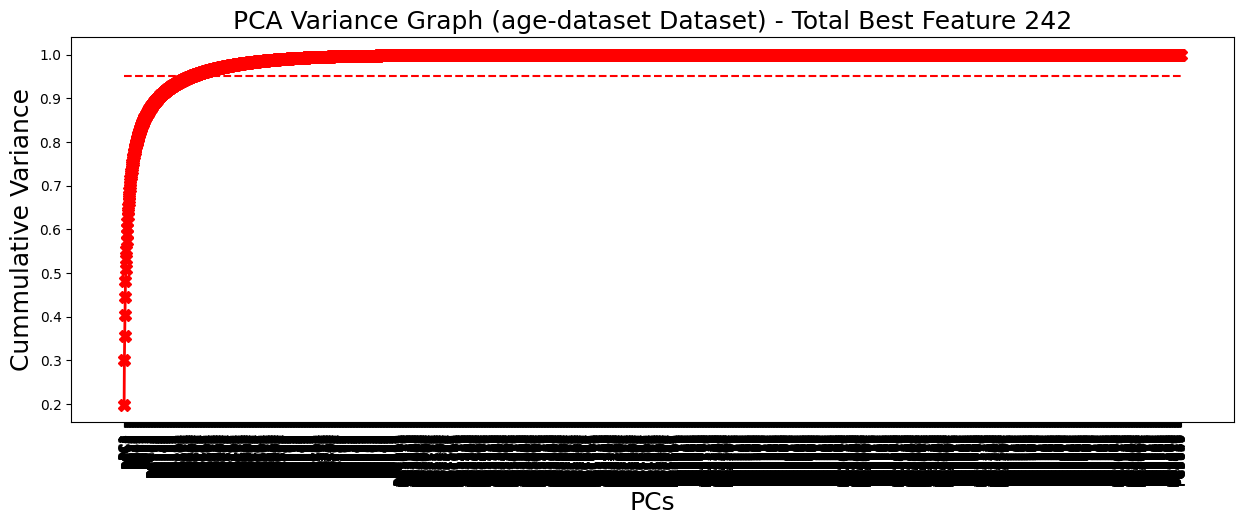

Final Total Feature We will use for PCA is 242
40/40 [==============================] - 9s 145ms/step
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007412 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 61710
[LightGBM] [Info] Number of data points in the train set: 5088, number of used features: 242
[LightGBM] [Info] Start training from score 22.500000
159/159 [==============================] - 25s 139ms/step


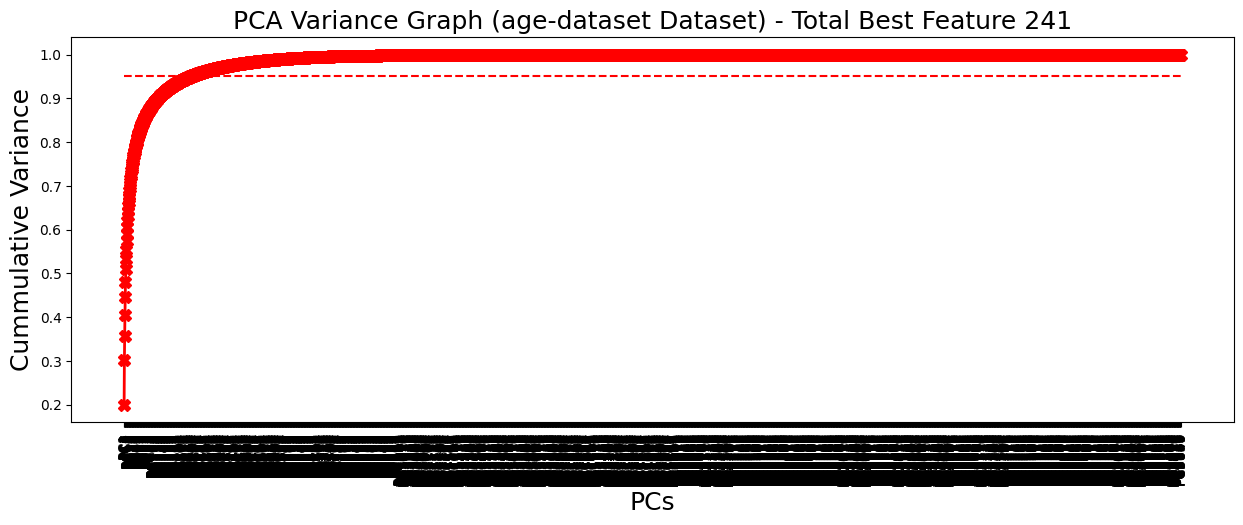

Final Total Feature We will use for PCA is 241
40/40 [==============================] - 9s 140ms/step
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005718 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 61455
[LightGBM] [Info] Number of data points in the train set: 5088, number of used features: 241
[LightGBM] [Info] Start training from score 22.500000
159/159 [==============================] - 25s 135ms/step


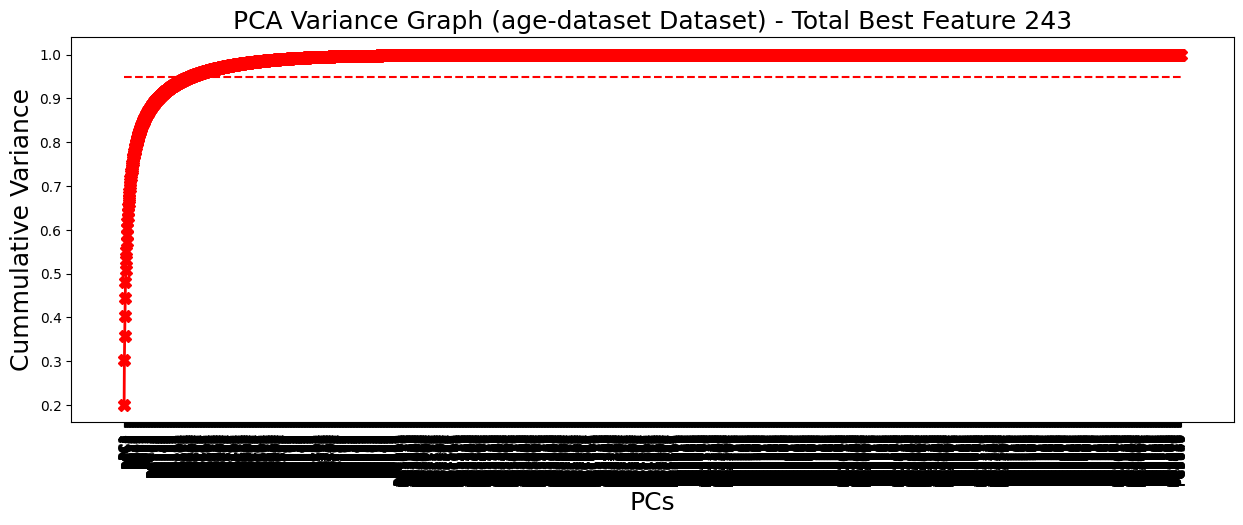

Final Total Feature We will use for PCA is 243
40/40 [==============================] - 9s 140ms/step
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005537 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 61965
[LightGBM] [Info] Number of data points in the train set: 5088, number of used features: 243
[LightGBM] [Info] Start training from score 22.500000
159/159 [==============================] - 25s 131ms/step


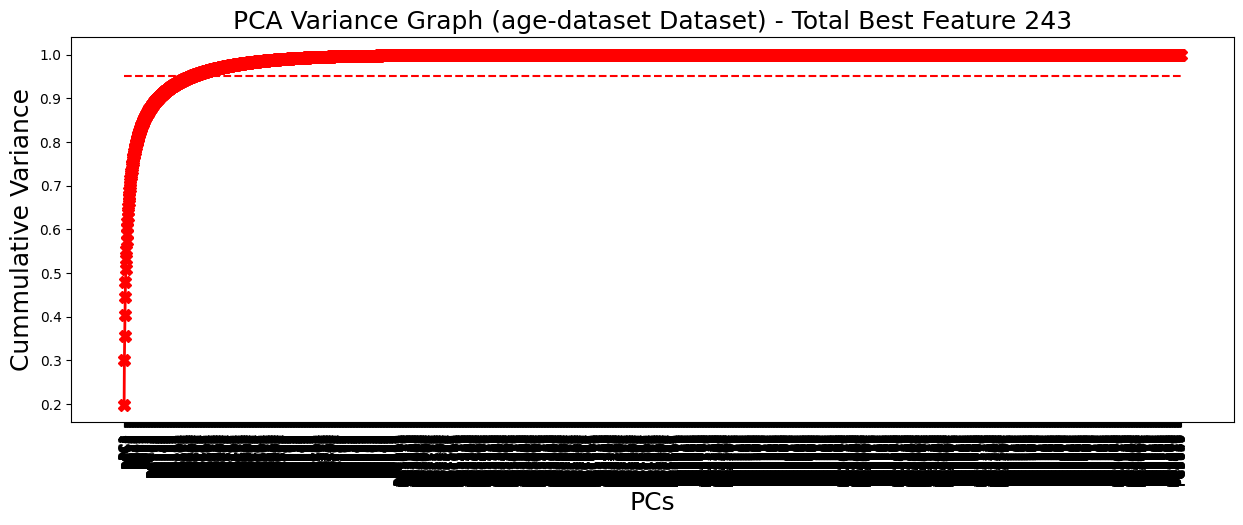

Final Total Feature We will use for PCA is 243
40/40 [==============================] - 9s 133ms/step
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005807 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 61965
[LightGBM] [Info] Number of data points in the train set: 5088, number of used features: 243
[LightGBM] [Info] Start training from score 22.500000
159/159 [==============================] - 25s 132ms/step


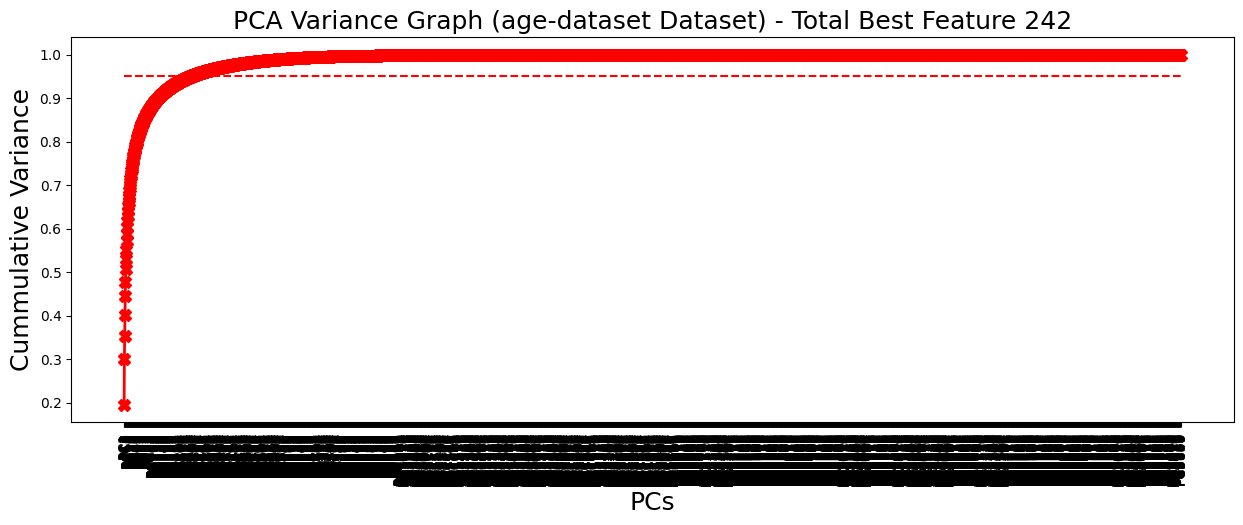

Final Total Feature We will use for PCA is 242
40/40 [==============================] - 9s 130ms/step
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005697 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 61710
[LightGBM] [Info] Number of data points in the train set: 5088, number of used features: 242
[LightGBM] [Info] Start training from score 22.500000


Model: LGBMRegressor - Iteration:2:   0%|          | 0/5 [00:00<?, ?it/s]

159/159 [==============================] - 25s 131ms/step


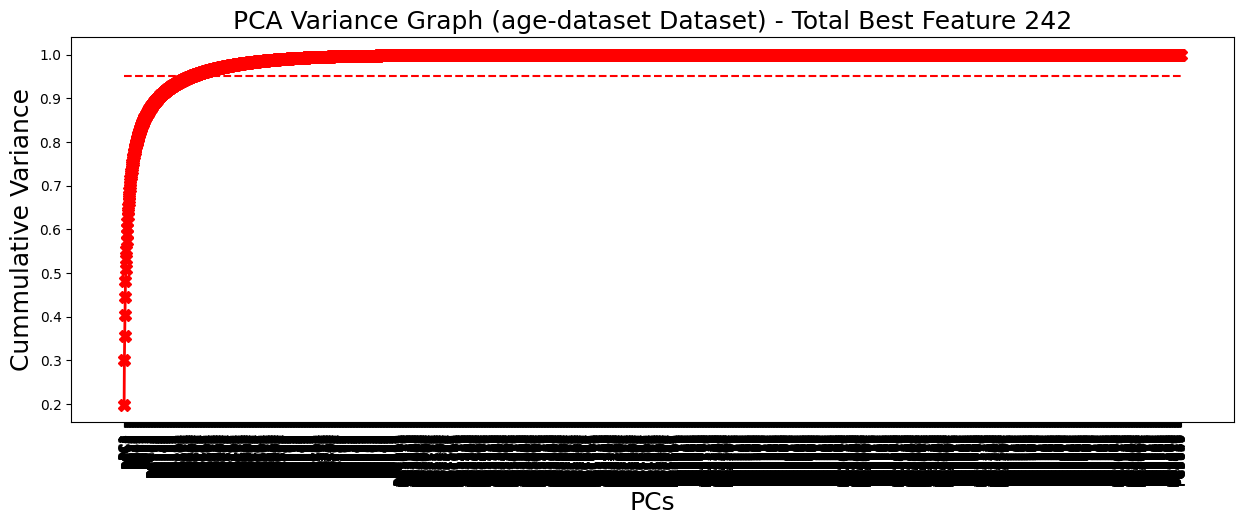

Final Total Feature We will use for PCA is 242
40/40 [==============================] - 9s 129ms/step
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012000 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 61710
[LightGBM] [Info] Number of data points in the train set: 5088, number of used features: 242
[LightGBM] [Info] Start training from score 22.500000
159/159 [==============================] - 25s 134ms/step


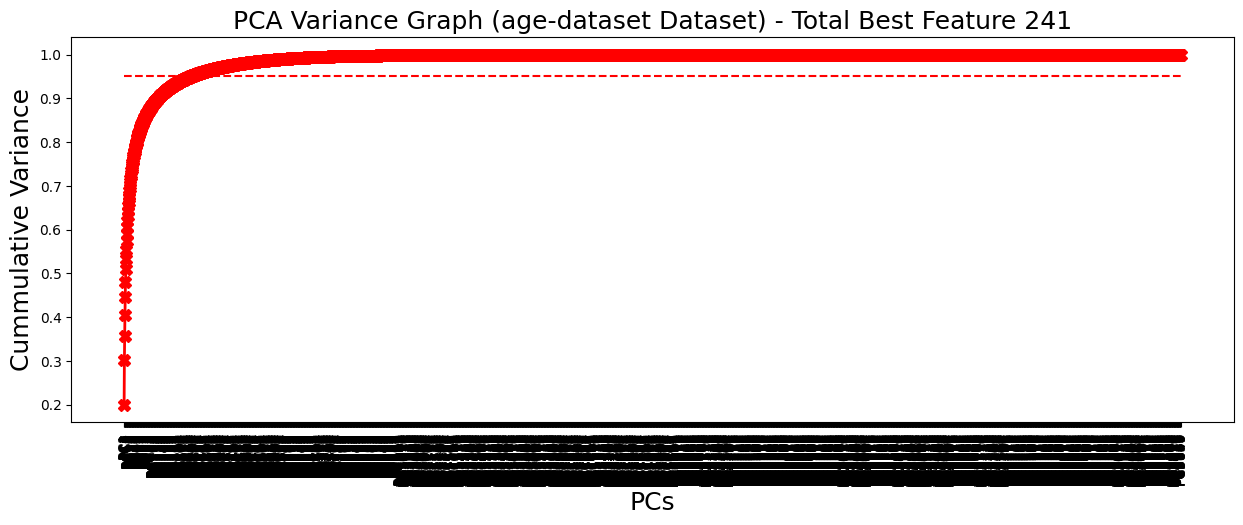

Final Total Feature We will use for PCA is 241
40/40 [==============================] - 9s 133ms/step
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013002 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 61455
[LightGBM] [Info] Number of data points in the train set: 5088, number of used features: 241
[LightGBM] [Info] Start training from score 22.500000
159/159 [==============================] - 24s 129ms/step


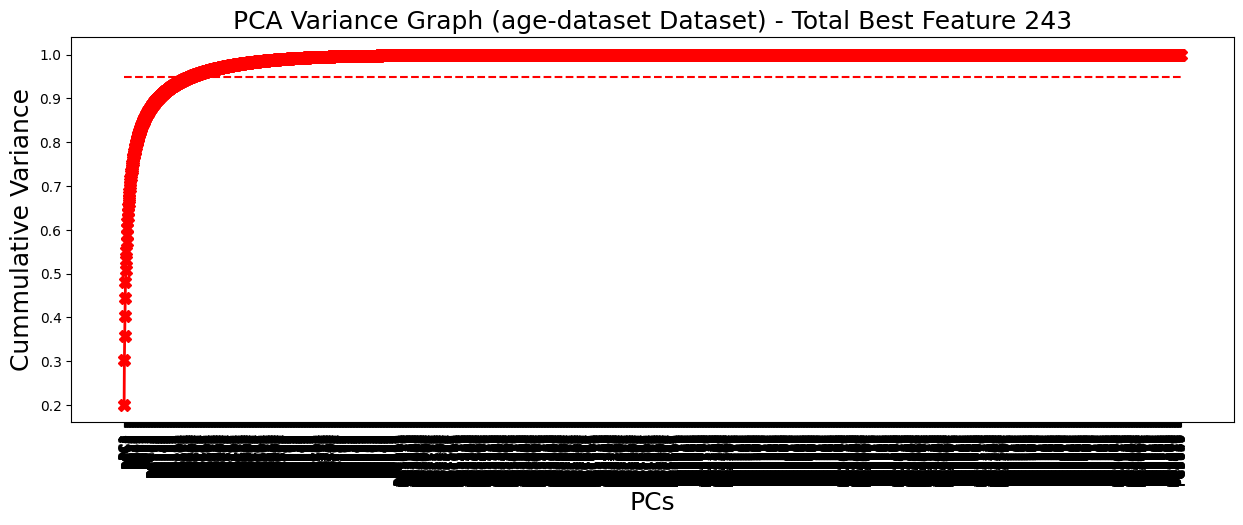

Final Total Feature We will use for PCA is 243
40/40 [==============================] - 9s 134ms/step
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015789 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 61965
[LightGBM] [Info] Number of data points in the train set: 5088, number of used features: 243
[LightGBM] [Info] Start training from score 22.500000
159/159 [==============================] - 25s 129ms/step


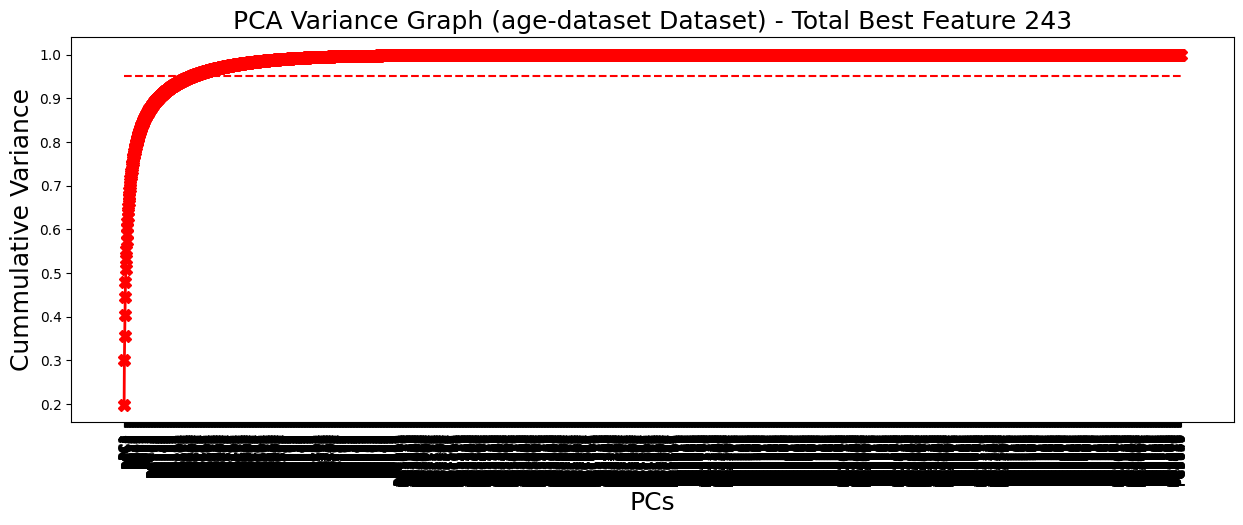

Final Total Feature We will use for PCA is 243
40/40 [==============================] - 9s 129ms/step
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005684 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 61965
[LightGBM] [Info] Number of data points in the train set: 5088, number of used features: 243
[LightGBM] [Info] Start training from score 22.500000
159/159 [==============================] - 24s 132ms/step


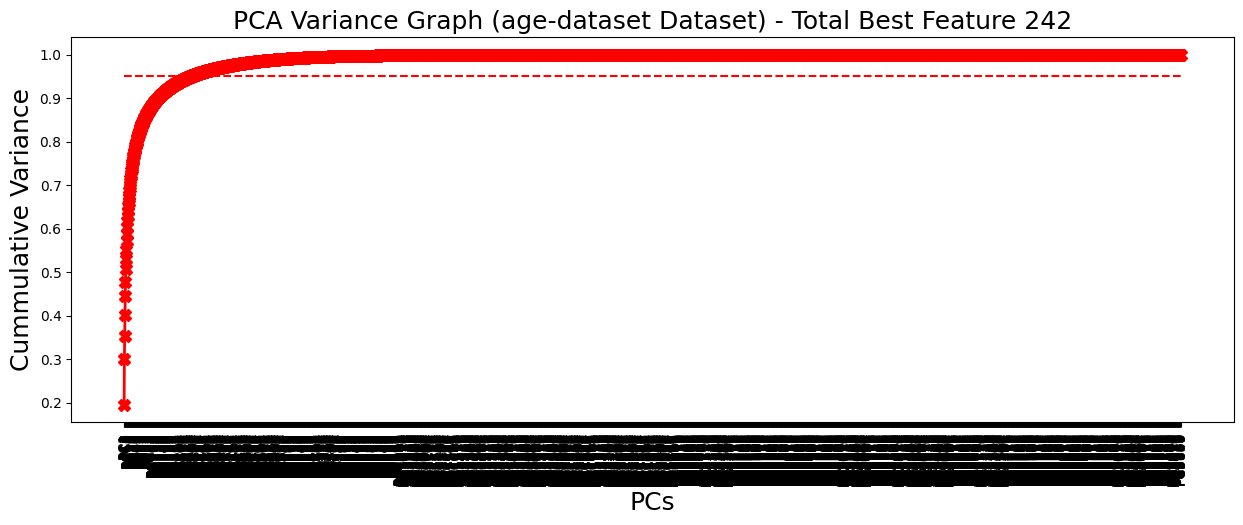

Final Total Feature We will use for PCA is 242
40/40 [==============================] - 9s 127ms/step
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005859 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 61710
[LightGBM] [Info] Number of data points in the train set: 5088, number of used features: 242
[LightGBM] [Info] Start training from score 22.500000


Model: LGBMRegressor - Iteration:3:   0%|          | 0/5 [00:00<?, ?it/s]

159/159 [==============================] - 24s 130ms/step


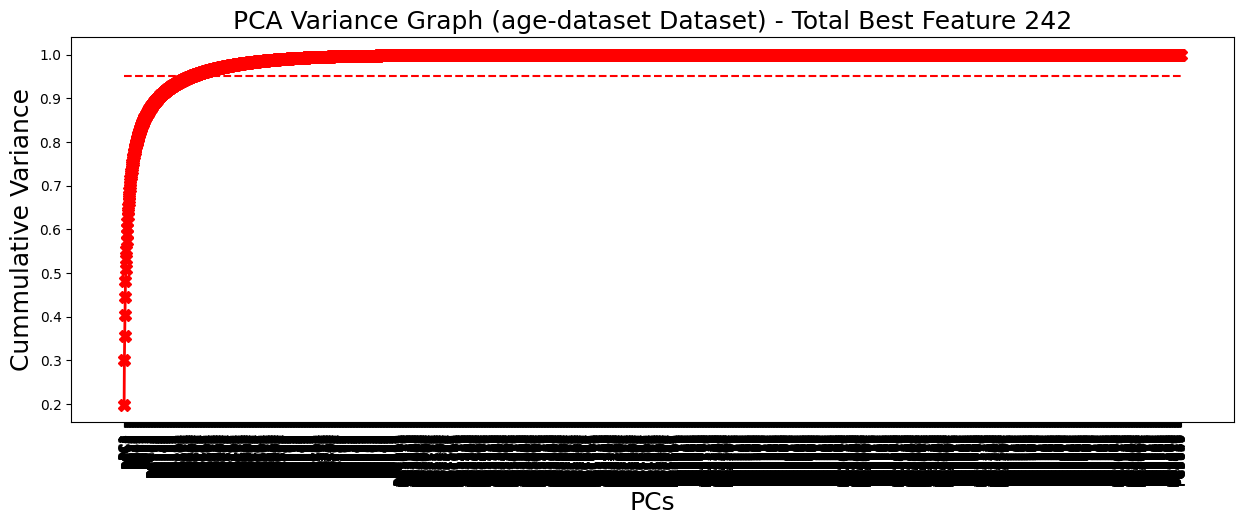

Final Total Feature We will use for PCA is 242
40/40 [==============================] - 9s 130ms/step
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005709 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 61710
[LightGBM] [Info] Number of data points in the train set: 5088, number of used features: 242
[LightGBM] [Info] Start training from score 22.500000
159/159 [==============================] - 25s 128ms/step


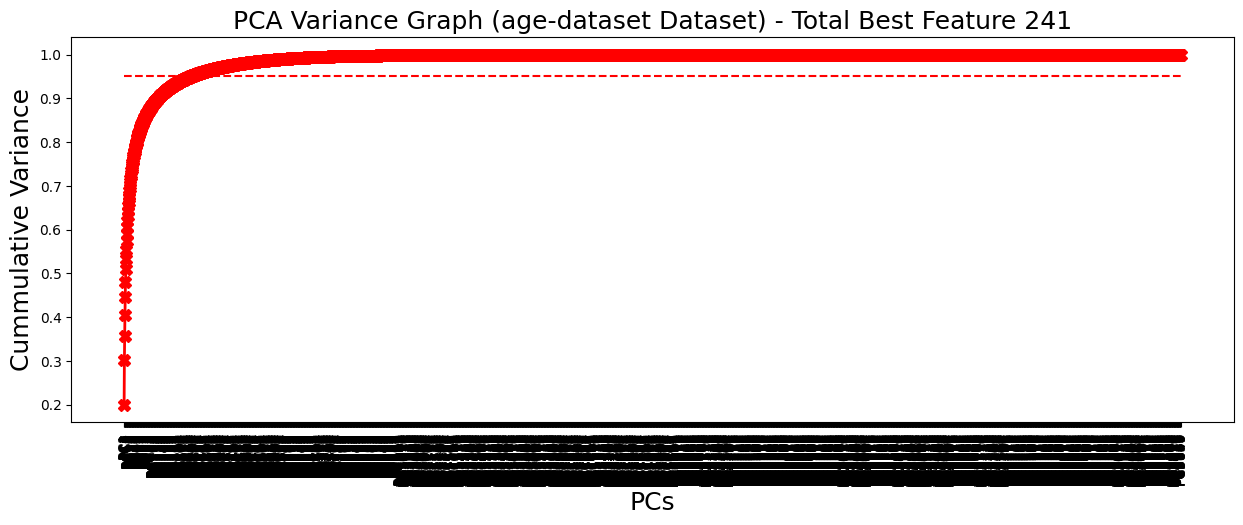

Final Total Feature We will use for PCA is 241
40/40 [==============================] - 9s 132ms/step
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005597 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 61455
[LightGBM] [Info] Number of data points in the train set: 5088, number of used features: 241
[LightGBM] [Info] Start training from score 22.500000
159/159 [==============================] - 24s 131ms/step


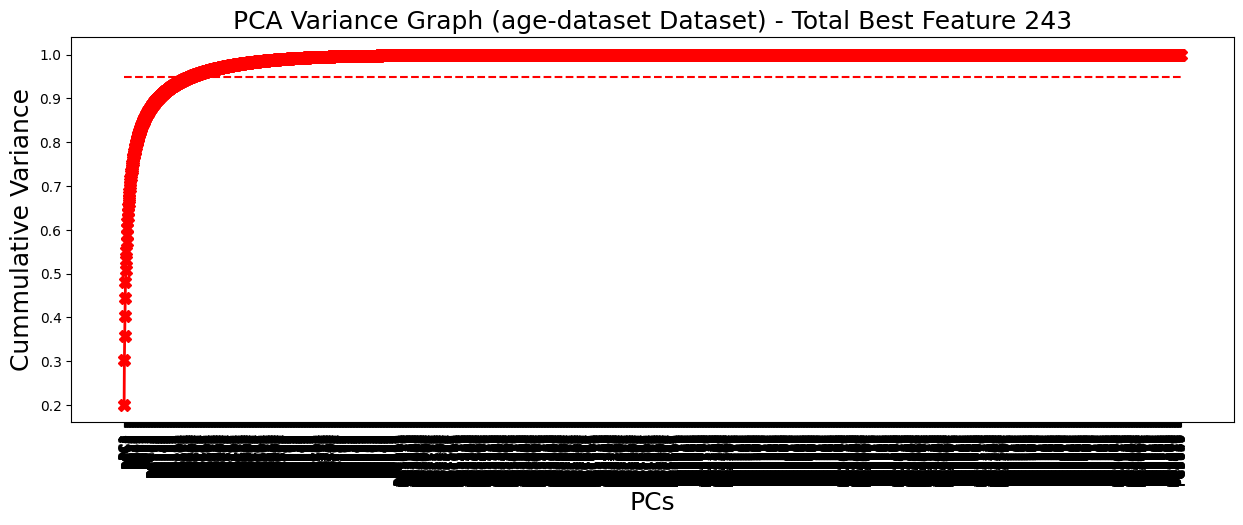

Final Total Feature We will use for PCA is 243
40/40 [==============================] - 9s 128ms/step
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013172 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 61965
[LightGBM] [Info] Number of data points in the train set: 5088, number of used features: 243
[LightGBM] [Info] Start training from score 22.500000
159/159 [==============================] - 25s 133ms/step


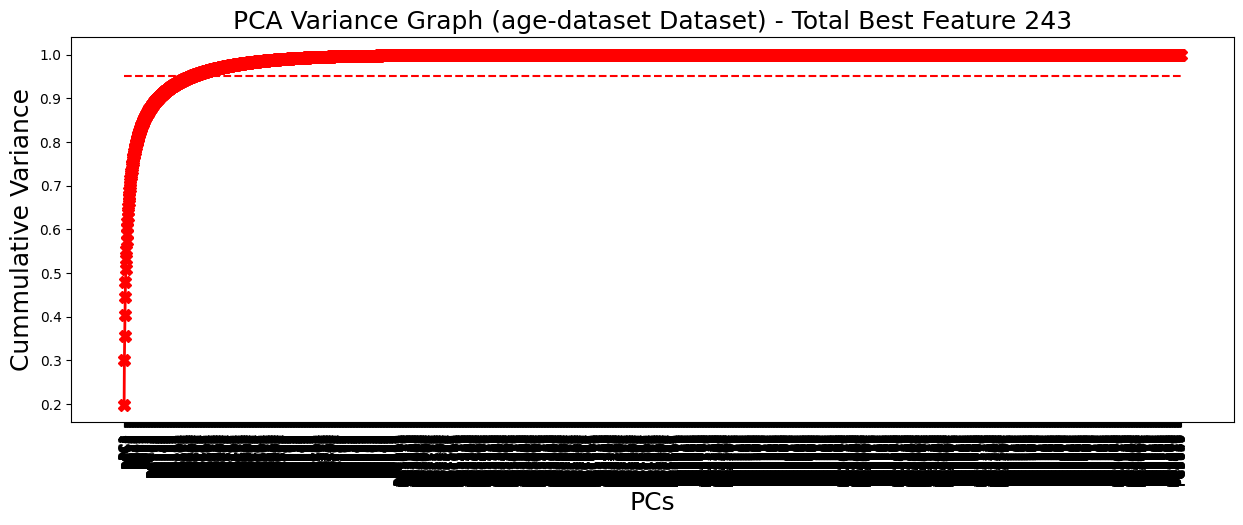

Final Total Feature We will use for PCA is 243
40/40 [==============================] - 9s 134ms/step
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011536 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 61965
[LightGBM] [Info] Number of data points in the train set: 5088, number of used features: 243
[LightGBM] [Info] Start training from score 22.500000
159/159 [==============================] - 25s 133ms/step


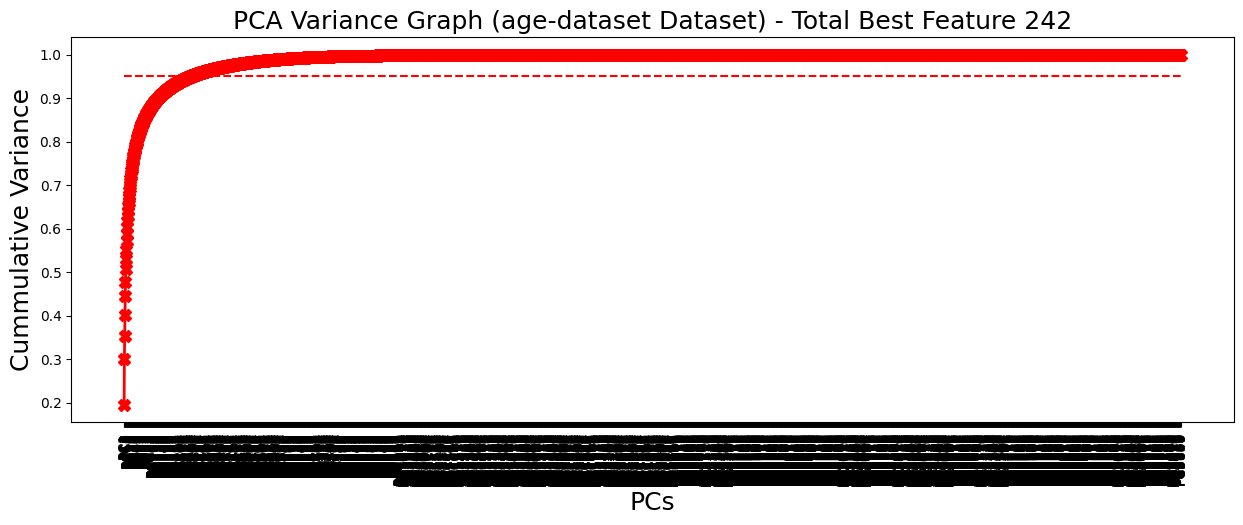

Final Total Feature We will use for PCA is 242
40/40 [==============================] - 9s 137ms/step
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005630 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 61710
[LightGBM] [Info] Number of data points in the train set: 5088, number of used features: 242
[LightGBM] [Info] Start training from score 22.500000


Model: LGBMRegressor - Iteration:4:   0%|          | 0/5 [00:00<?, ?it/s]

159/159 [==============================] - 24s 127ms/step


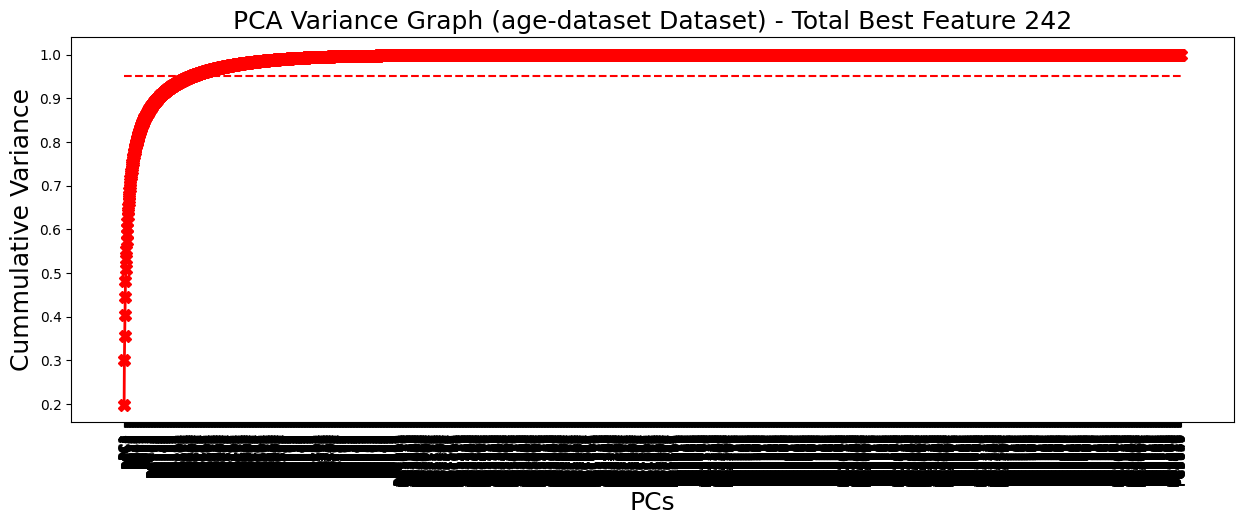

Final Total Feature We will use for PCA is 242
40/40 [==============================] - 9s 134ms/step
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006762 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 61710
[LightGBM] [Info] Number of data points in the train set: 5088, number of used features: 242
[LightGBM] [Info] Start training from score 22.500000
159/159 [==============================] - 24s 132ms/step


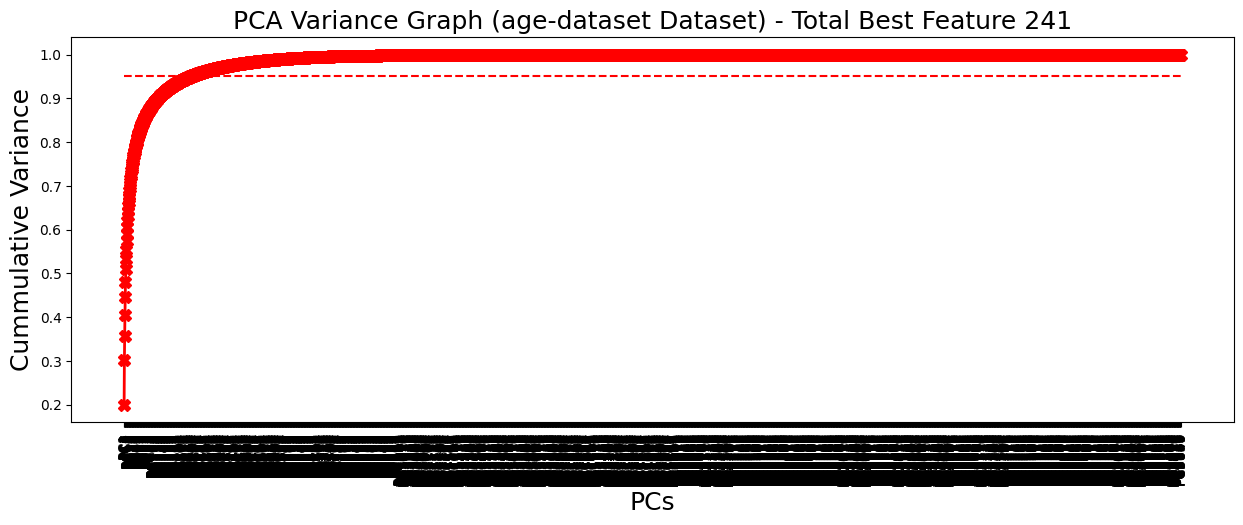

Final Total Feature We will use for PCA is 241
40/40 [==============================] - 9s 130ms/step
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005627 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 61455
[LightGBM] [Info] Number of data points in the train set: 5088, number of used features: 241
[LightGBM] [Info] Start training from score 22.500000
159/159 [==============================] - 24s 132ms/step


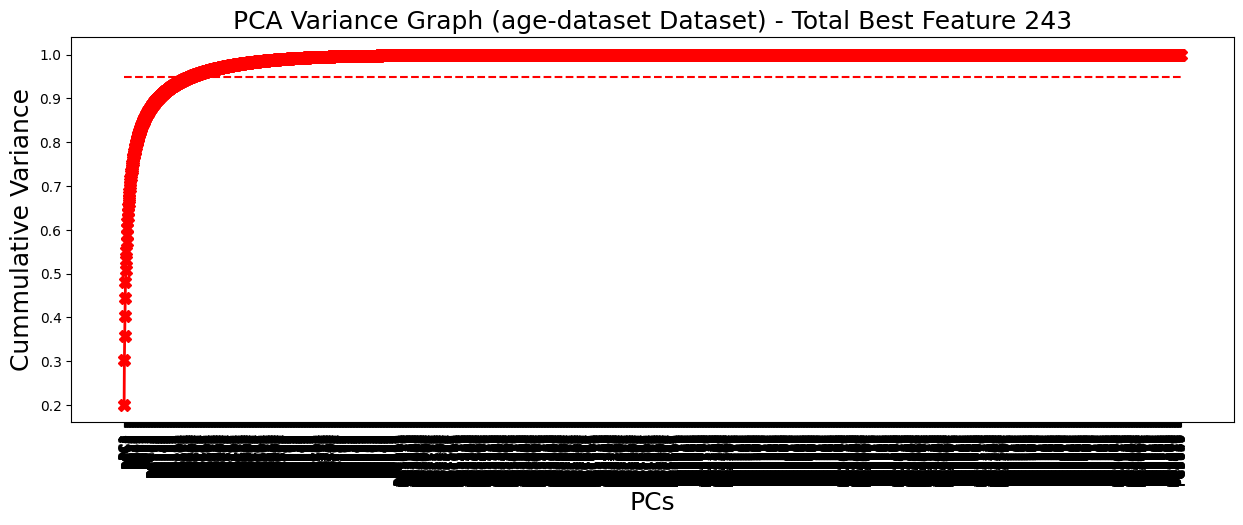

Final Total Feature We will use for PCA is 243
40/40 [==============================] - 9s 129ms/step
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005538 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 61965
[LightGBM] [Info] Number of data points in the train set: 5088, number of used features: 243
[LightGBM] [Info] Start training from score 22.500000
159/159 [==============================] - 24s 130ms/step


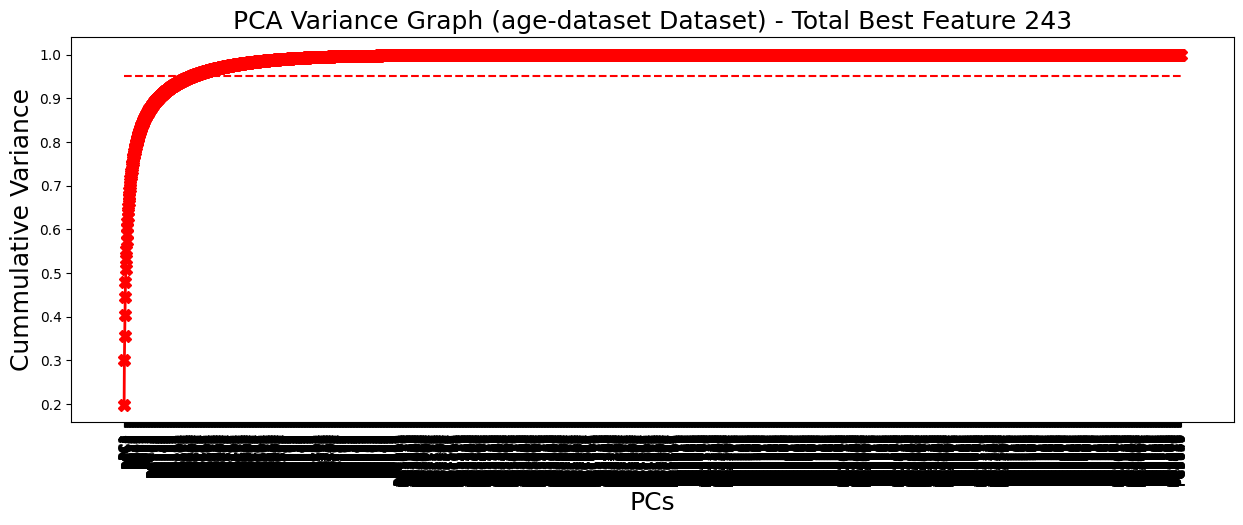

Final Total Feature We will use for PCA is 243
40/40 [==============================] - 9s 129ms/step
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005614 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 61965
[LightGBM] [Info] Number of data points in the train set: 5088, number of used features: 243
[LightGBM] [Info] Start training from score 22.500000
159/159 [==============================] - 24s 131ms/step


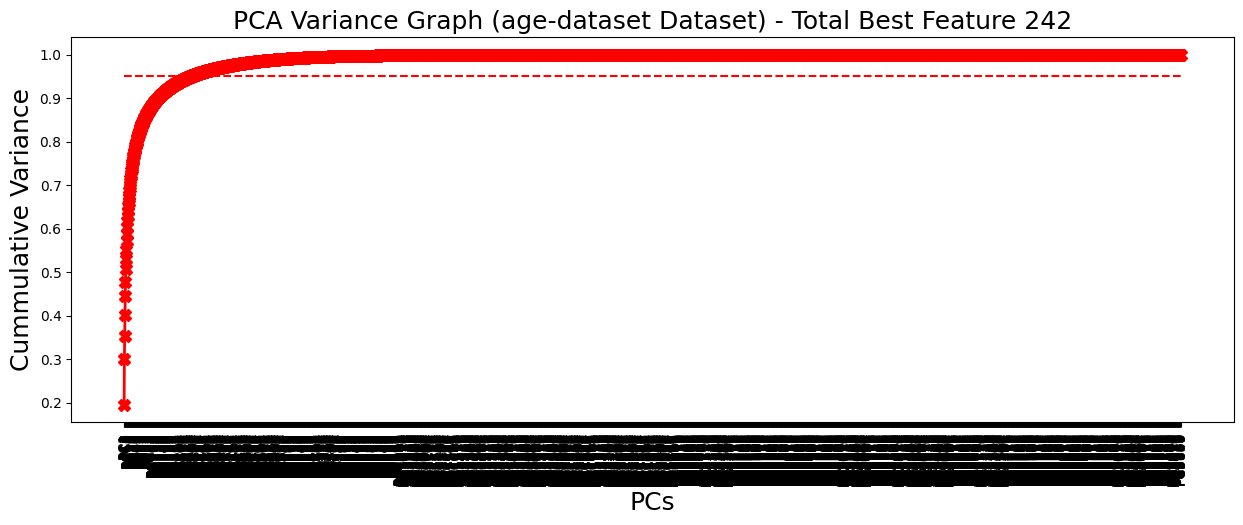

Final Total Feature We will use for PCA is 242
40/40 [==============================] - 9s 148ms/step
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005768 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 61710
[LightGBM] [Info] Number of data points in the train set: 5088, number of used features: 242
[LightGBM] [Info] Start training from score 22.500000


Model: LGBMRegressor - Iteration:5:   0%|          | 0/5 [00:00<?, ?it/s]

159/159 [==============================] - 25s 133ms/step


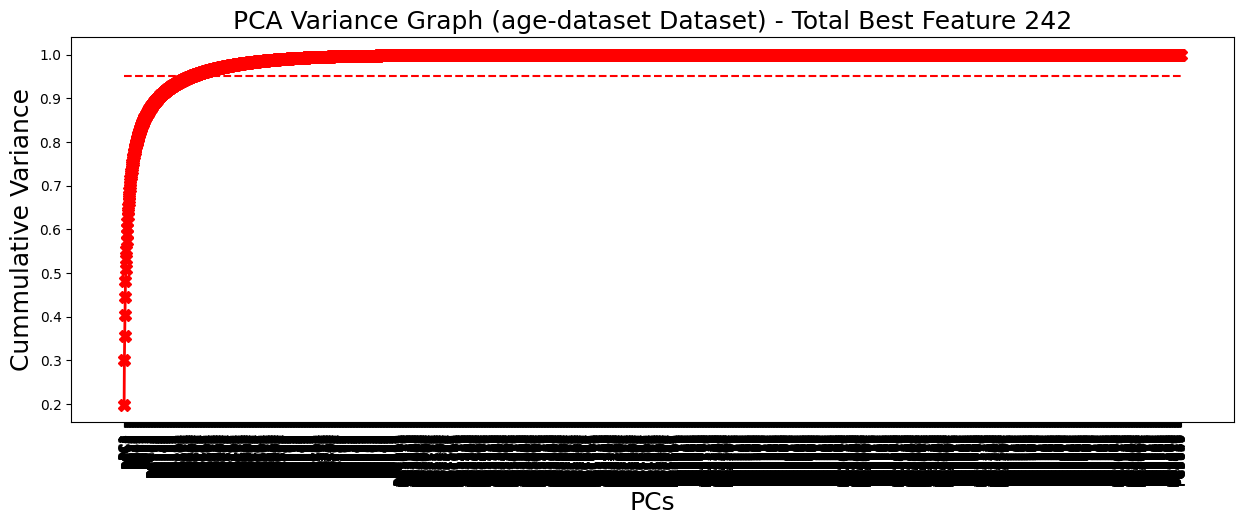

Final Total Feature We will use for PCA is 242
40/40 [==============================] - 8s 127ms/step
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005725 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 61710
[LightGBM] [Info] Number of data points in the train set: 5088, number of used features: 242
[LightGBM] [Info] Start training from score 22.500000
159/159 [==============================] - 24s 131ms/step


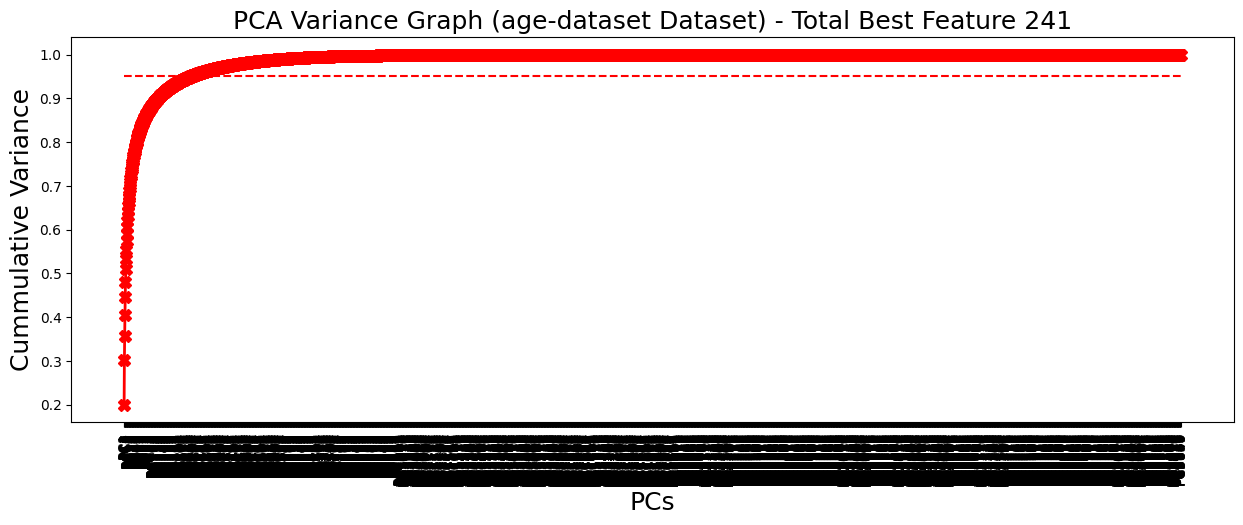

Final Total Feature We will use for PCA is 241
40/40 [==============================] - 9s 129ms/step
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005920 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 61455
[LightGBM] [Info] Number of data points in the train set: 5088, number of used features: 241
[LightGBM] [Info] Start training from score 22.500000
159/159 [==============================] - 25s 135ms/step


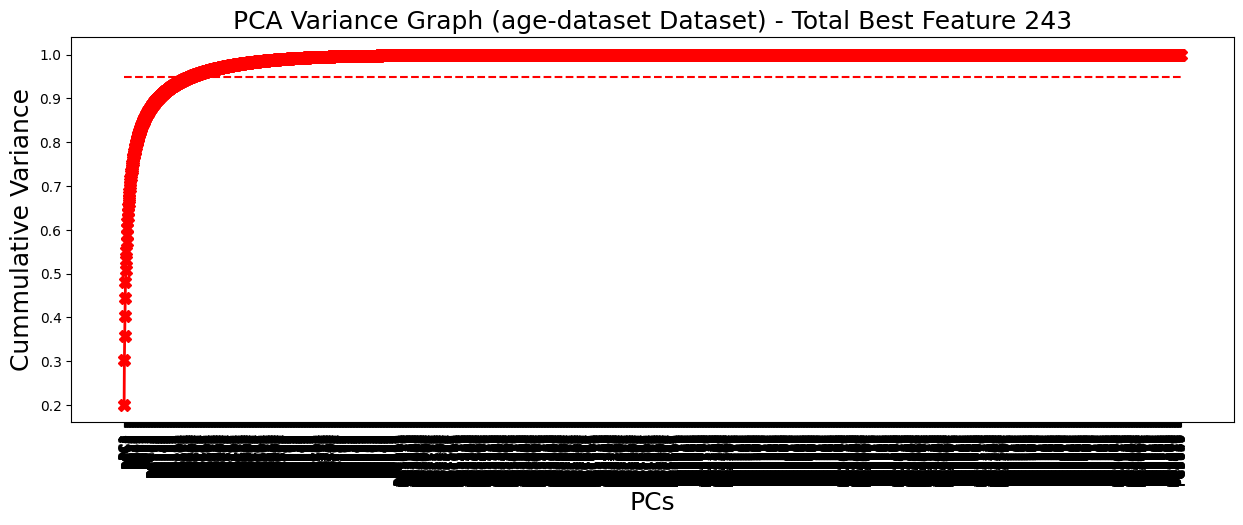

Final Total Feature We will use for PCA is 243
40/40 [==============================] - 9s 130ms/step
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011982 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 61965
[LightGBM] [Info] Number of data points in the train set: 5088, number of used features: 243
[LightGBM] [Info] Start training from score 22.500000
159/159 [==============================] - 24s 131ms/step


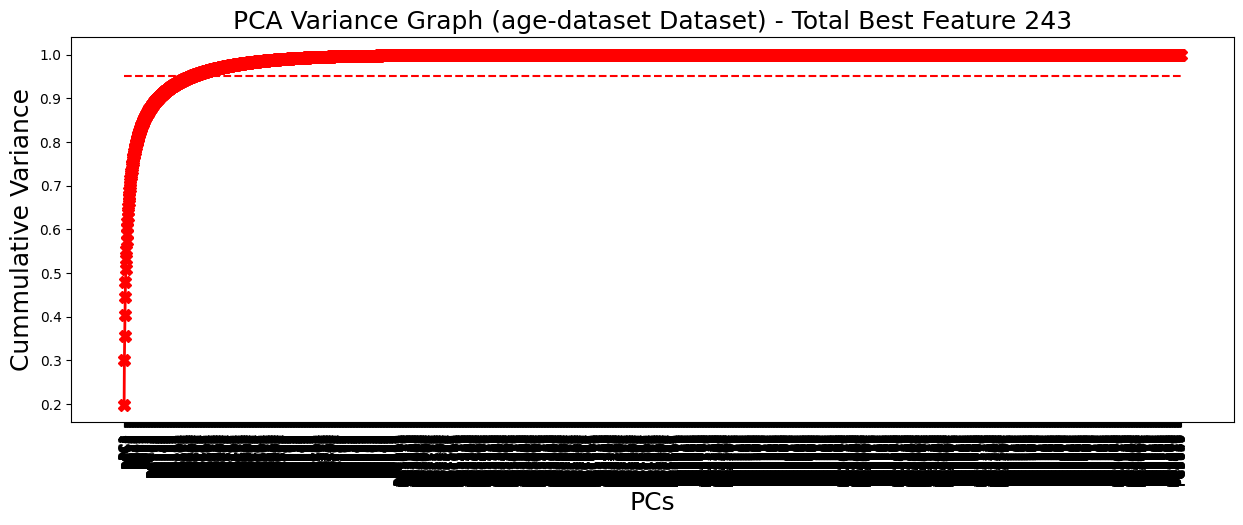

Final Total Feature We will use for PCA is 243
40/40 [==============================] - 9s 132ms/step
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012026 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 61965
[LightGBM] [Info] Number of data points in the train set: 5088, number of used features: 243
[LightGBM] [Info] Start training from score 22.500000
159/159 [==============================] - 25s 133ms/step


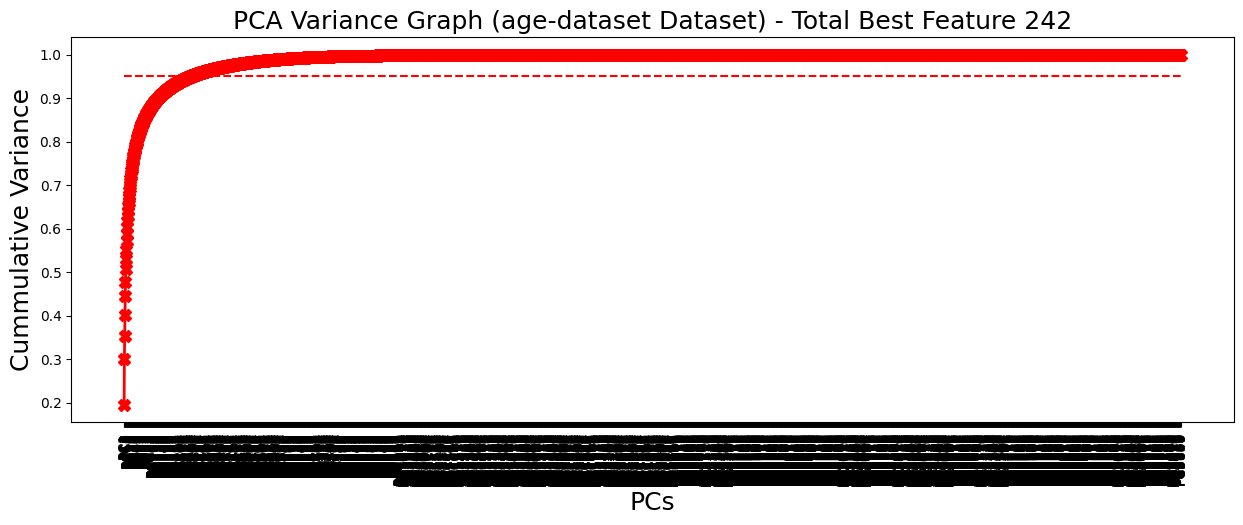

Final Total Feature We will use for PCA is 242
40/40 [==============================] - 9s 134ms/step
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005812 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 61710
[LightGBM] [Info] Number of data points in the train set: 5088, number of used features: 242
[LightGBM] [Info] Start training from score 22.500000


In [ ]:
params = {'boosting_type': 'gbdt', 'class_weight': None,
          'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1,
          'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0,
          'n_estimators': 100, 'n_jobs': None, 'num_leaves': 31, 'objective': None, 'random_state': None,
          'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0}
model = LGBMRegressor(**params)

res_rf, res_avg_rf = kfold_crossvalidation(image_data, labels, model)

In [ ]:
def save_results_file(results_df, results_df_avg, model_name):
  results_df.to_csv(f"/content/drive/MyDrive/Hands Dataset/Results/{model_name}_results.csv", index=False)
  results_df_avg.to_csv(f"/content/drive/MyDrive/Hands Dataset/Results/{model_name}_results_avg.csv", index=False)
  print("Results saved successfully!")

In [ ]:
save_results_file(res_rf, res_avg_rf, "LGBMRegressor")

Results saved successfully!


In [ ]:
import pandas as pd
df_lgbm = pd.read_csv("/content/drive/MyDrive/Hands Dataset/Results/LGBMRegressor_results.csv")
df_lgbm_avg = pd.read_csv("/content/drive/MyDrive/Hands Dataset/Results/LGBMRegressor_results_avg.csv")

1. In Fold 1 shows decent performance with a relatively low MSE, RMSE indicating that the model predictions are reasonably close to actual values. The  R squared score  of 0.71 suggests that approximately 71% of the variance in the target variable is explained by the model. 
2. In Fold 2 the MSE and RMSE increase slightly compared to Fold 1 indicating a slightly worse fit. However, the R squared score is still reasonable at 0.69 suggesting that the model is still explaining a good portion of the variance in the data . 
3. In Fold 3 similar to Fold 2 the level of error in predictions. However, R squared score is consistent at around 0.69 indicating a stable performance in explaining the variance.
4. In Fold 4, there is a slight improvement in performance compared to Fold 3 slightly lower MSE and RMSE, R squared score also increase slightly to 0.70 indicating a better fit of the model to the data.
5. In Fold 5, performance is similar to Fold 1 with a relatively low MSE and RMSE and a high R squared score of 0.71 suggesting the model is explaining a good portion of the variance in the target variables.
Overall in each folds model demonstrates consistent performance R squared score ranging from approximately 0.69 to 0.71 indicating a decent fit to the data. While there are some variations in MSE and RMSE between folds.

In [ ]:
df_lgbm

,Model,Fold,MSE,RMSE,R2 Score,Iteration
0,LGBMRegressor,1,1.534907,1.238914,0.707637,1
1,LGBMRegressor,2,1.604846,1.266825,0.694315,1
2,LGBMRegressor,3,1.636077,1.279092,0.688366,1
3,LGBMRegressor,4,1.577596,1.256024,0.699505,1
4,LGBMRegressor,5,1.537465,1.239946,0.707150,1
5,LGBMRegressor,1,1.546824,1.243714,0.705367,2
6,LGBMRegressor,2,1.622396,1.273733,0.690972,2
7,LGBMRegressor,3,1.592257,1.261847,0.696713,2
8,LGBMRegressor,4,1.547677,1.244057,0.705204,2
9,LGBMRegressor,5,1.527975,1.236113,0.708957,2


In [ ]:
df_lgbm_avg

,Model,Iteration,MSE,RMSE,R2 Score
0,LGBMRegressor,1,1.578178,1.256160,0.699395
1,LGBMRegressor,2,1.567426,1.251893,0.701443
2,LGBMRegressor,3,1.574520,1.254714,0.700092
3,LGBMRegressor,4,1.584308,1.258547,0.698227
4,LGBMRegressor,5,1.542629,1.241938,0.706166


plot_results is used to visualize the performance of a regression model across different iterations and folds using line plots matplotlib.pyplot and seaborn libraries are imported for plotting. A custom_palette is defined using the 'husl' color scheme from seaborn. The number of colors in the palette is equal to the number of unique folds in the dataset. A figure with three subplots is created using plt.subplots(). each subplot represents the model performance in terms of MSE, RMSE and R squred score. sns.lineplot() is used to plot the model performance metrics (MSE, RMSE, R squared against the iteration. hue parameter is set to fold to differentiate lines representing different folds. Markerstyle 'o' is used to plot data points. custom_palette is applied to differentiate lines representing different fold, axes labels, titles, legends, ticktitles are set accordingly. fig.suptitle() describes the overall purpose of the plots the model name is extracted from the input DataFrame. plt.tight_layout() is used to adjust subplot parameters for better spacing and plt.show() display the plot.

In [ ]:
def plot_results(df_rf):
  import matplotlib.pyplot as plt
  import seaborn as sns

  custom_palette = sns.color_palette("husl", n_colors=len(df_rf["Fold"].unique()))

  fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 6))

  # Plot MSE for each fold
  sns.lineplot(data=df_rf, x="Iteration", y="MSE", hue="Fold", marker="o", palette=custom_palette, ax=axes[0])
  axes[0].set_xlabel("Iteration")
  axes[0].set_ylabel("MSE")
  axes[0].set_title("Model Performance (MSE) - Iteration vs. Fold")
  axes[0].legend(title="Fold", loc="upper right", bbox_to_anchor=(1.2, 1))
  axes[0].set_xticks(df_rf["Iteration"].unique())
  axes[0].set_xticklabels(df_rf["Iteration"].unique(), rotation=45)

  # Plot RMSE for each fold
  sns.lineplot(data=df_rf, x="Iteration", y="RMSE", hue="Fold", marker="o", palette=custom_palette, ax=axes[1])
  axes[1].set_xlabel("Iteration")
  axes[1].set_ylabel("RMSE")
  axes[1].set_title("Model Performance (RMSE) - Iteration vs. Fold")
  axes[1].legend(title="Fold", loc="upper right", bbox_to_anchor=(1.2, 1))
  axes[1].set_xticks(df_rf["Iteration"].unique())
  axes[1].set_xticklabels(df_rf["Iteration"].unique(), rotation=45)

  # Plot R2 for each fold
  sns.lineplot(data=df_rf, x="Iteration", y="R2 Score", hue="Fold", marker="o", palette=custom_palette, ax=axes[2])
  axes[2].set_xlabel("Iteration")
  axes[2].set_ylabel("R2")
  axes[2].set_title("Model Performance (R2) - Iteration vs. Fold")
  axes[2].legend(title="Fold", loc="upper right", bbox_to_anchor=(1.2, 1))
  axes[2].set_xticks(df_rf["Iteration"].unique())
  axes[2].set_xticklabels(df_rf["Iteration"].unique(), rotation=45)

  fig.suptitle(f"Model Performance Evaluation ({df_rf['Model'].unique()[0]})", fontsize=16, y=1.05)
  plt.tight_layout()
  plt.show()


def plot_results_avg(df_rf_avg):
  import matplotlib.pyplot as plt
  import seaborn as sns

  custom_palette = sns.color_palette("husl")
  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

  # Plot MSE and RMSE for each iteration
  sns.lineplot(data=df_rf_avg, x="Iteration", y="MSE", marker="o", color=custom_palette[0], label="MSE", ax=axes[0])
  sns.lineplot(data=df_rf_avg, x="Iteration", y="RMSE", marker="o", color=custom_palette[1], label="RMSE", ax=axes[0])
  axes[0].set_xlabel("Iteration")
  axes[0].set_ylabel("Error")
  axes[0].set_title("Model Performance (MSE and RMSE) - Iteration")
  axes[0].set_xticks(df_rf_avg["Iteration"])
  axes[0].set_xticklabels(df_rf_avg["Iteration"], rotation=45)
  axes[0].legend()

  # Plot R2 for each iteration
  sns.lineplot(data=df_rf_avg, x="Iteration", y="R2 Score", marker="o", color=custom_palette[2], ax=axes[1])
  axes[1].set_xlabel("Iteration")
  axes[1].set_ylabel("R2 Score")
  axes[1].set_title("Model Performance (R2) - Iteration")
  axes[1].set_xticks(df_rf_avg["Iteration"])
  axes[1].set_xticklabels(df_rf_avg["Iteration"], rotation=45)

  fig.suptitle(f"Model Performance Evaluation ({df_rf_avg['Model'].unique()[0]})", fontsize=16, y=1.05)
  plt.tight_layout()
  plt.show()

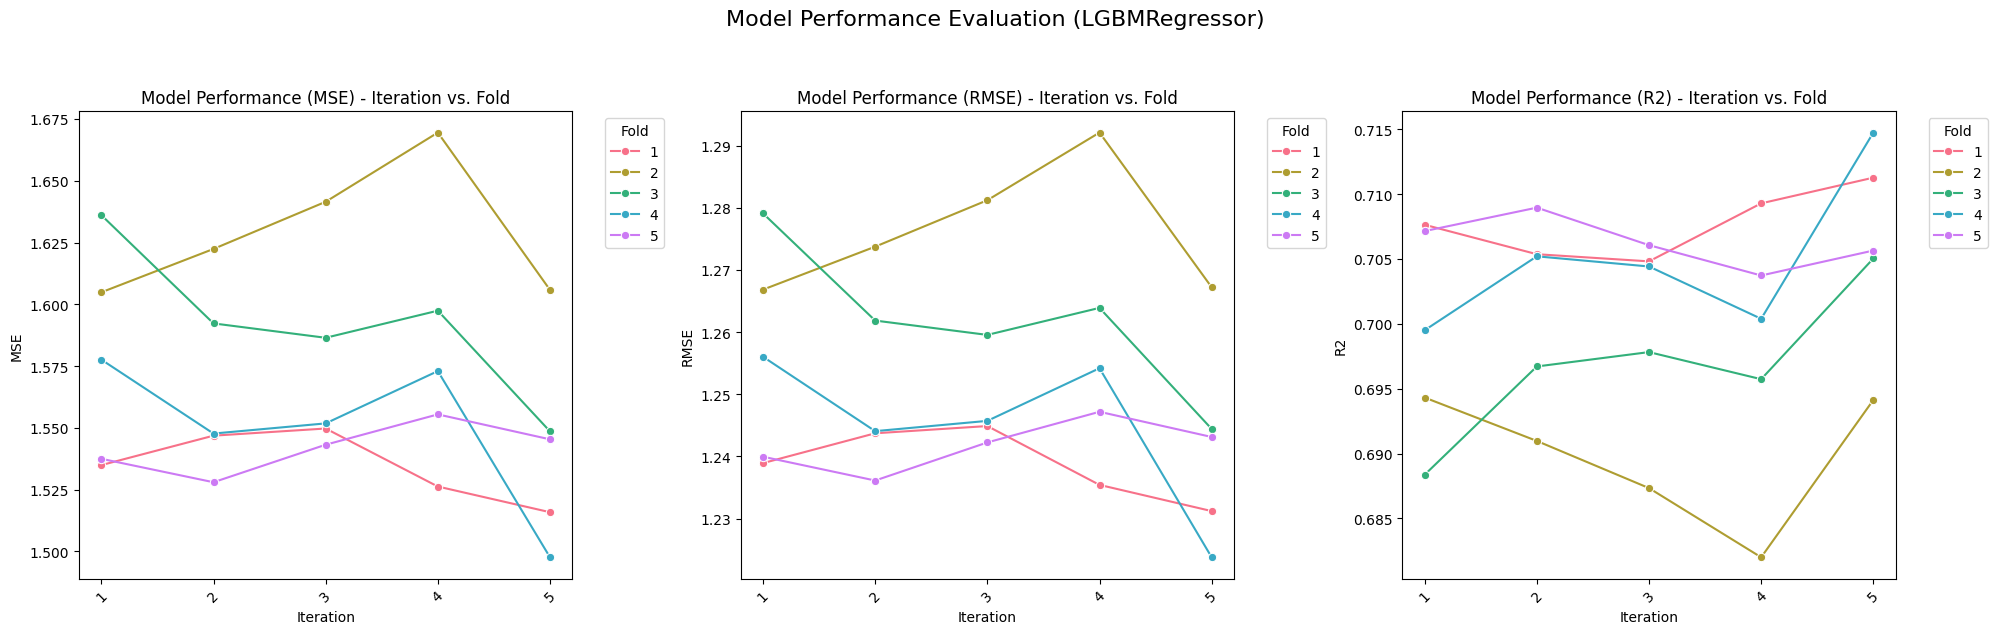

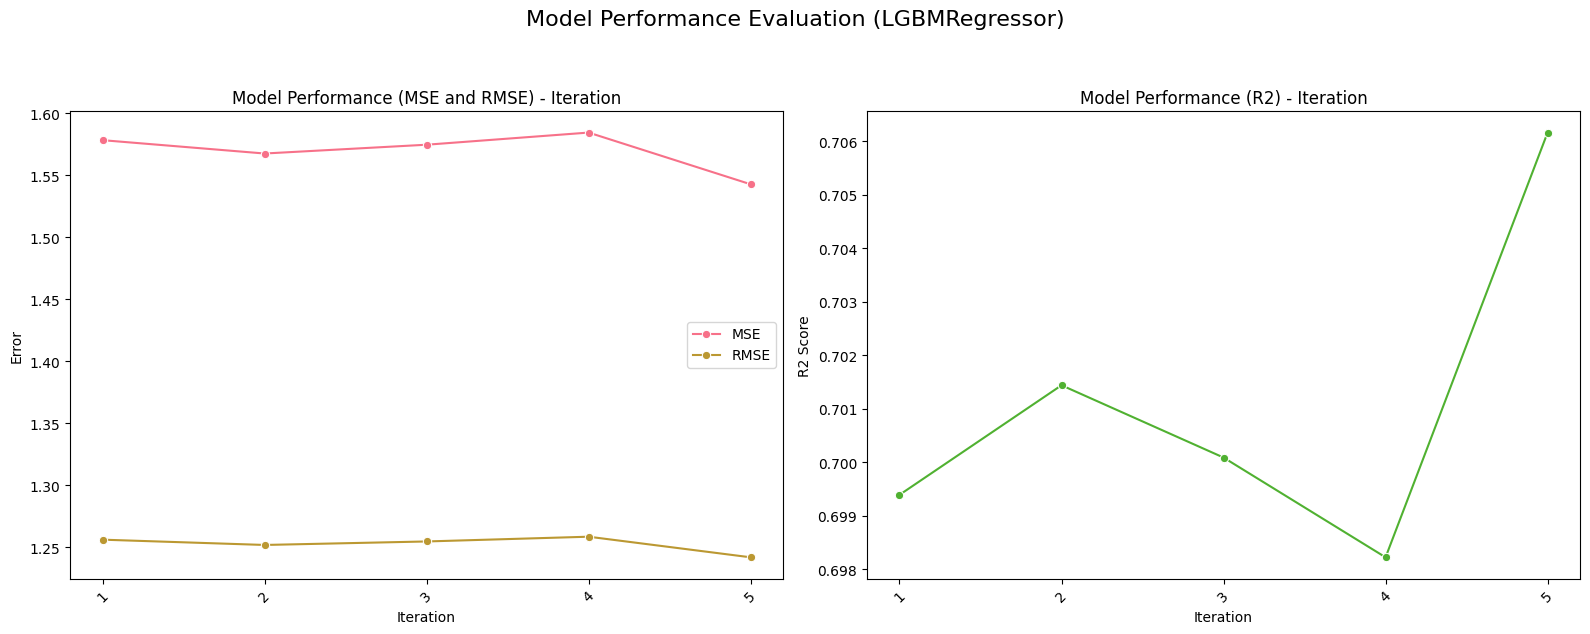

In [ ]:
plot_results(df_lgbm)
plot_results_avg(df_lgbm_avg)